# Лабораторная №4. Обработка звука

#### Imports

In [2]:
import numpy as np
import pandas as pd
import torchaudio
import soundfile as sf
import torch
import torch.nn as nn
import random
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.optim as optim
import umap
import matplotlib.pyplot as plt
from IPython.display import Audio, display

### Dataset

In [3]:
sf.info("wavfiles/11713-0.wav")

wavfiles/11713-0.wav
samplerate: 22050 Hz
channels: 1
duration: 3.000 s
format: WAV (Microsoft) [WAV]
subtype: 32 bit float [FLOAT]

In [4]:
sample_rate = 22050
batch_size = 100

loss_function = nn.CrossEntropyLoss()


In [5]:
table = pd.read_csv('bird_songs_metadata.csv')
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB


In [25]:
table.head()

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [7]:
print(table.species.unique())

['bewickii' 'polyglottos' 'migratorius' 'melodia' 'cardinalis']


In [8]:
spicies_to_int = {}
int_to_spicies = []
spicies_count = len(table.species.unique())
for v in table.species.unique():
    spicies_to_int[v] = len(spicies_to_int)
    int_to_spicies.append(v)

data = []
for i in range(0, table.shape[0]):
    data.append((table.filename[i], spicies_to_int[table.species[i]], i))

In [9]:
random.shuffle(data)
train_data = data[:-1022]
test_data = data[-1022:]
print(len(train_data))
print(len(test_data))

4400
1022


In [10]:
class BirdDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        file_name, class_, _ = self.data[index]
        sound, rate = torchaudio.load('wavfiles/' + file_name, normalize=True)
        res = torch.zeros(spicies_count, dtype=torch.float32)
        res[class_] = 1.0
        return sound[0], res

In [11]:
train_loader = DataLoader(dataset=BirdDataset(train_data), batch_size=batch_size, shuffle=True)

### Model

In [12]:
class BirdClassifier(nn.Module):
    def __init__(self):
        super(BirdClassifier, self).__init__()
        self.lfcc = torchaudio.transforms.LFCC(
            sample_rate=sample_rate,
            n_lfcc=256,
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 10) # for embeddings
        self.fc2 = nn.Linear(10, 5) # for classes

    def forward(self, x):
        x = self.lfcc(x)
        x = x.permute(0, 2, 1)
        _, (_, x) = self.lstm(x)
        x = x.reshape(x.size(1), -1)
        x = self.fc(x)
        x = self.fc2(x)
        return x
    
    def get_embedings(self, x):
        x = self.lfcc(x)
        x = x.permute(1, 0)
        _, (_, x) = self.lstm(x)
        x = x.reshape(-1)
        x = self.fc(x)
        return x
model = BirdClassifier()

In [13]:
def train_model(model, optimizer, train_loader, epoches = 25):
    model.train()
    train_loss = []
    for epoch in range(epoches):
        print(f"epoch {epoch}/{epoches}")
        for i, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            train_loss.append(loss.data.item())
            optimizer.step()
            if ((i + 1) % 10 == 0):
                print(f"step: {i+1}/{len(train_loader)}\tloss: {loss.item():.3f}")

In [14]:
train_model(model, optim.Adam(model.parameters(), lr=0.001), train_loader)

epoch 0/25


step: 10/44	loss: 9.768
step: 20/44	loss: 7.219
step: 30/44	loss: 3.590
step: 40/44	loss: 2.731
epoch 1/25
step: 10/44	loss: 2.042
step: 20/44	loss: 2.379
step: 30/44	loss: 1.304
step: 40/44	loss: 1.071
epoch 2/25
step: 10/44	loss: 0.834
step: 20/44	loss: 0.908
step: 30/44	loss: 1.048
step: 40/44	loss: 0.903
epoch 3/25
step: 10/44	loss: 0.691
step: 20/44	loss: 0.793
step: 30/44	loss: 0.701
step: 40/44	loss: 0.702
epoch 4/25
step: 10/44	loss: 0.605
step: 20/44	loss: 0.594
step: 30/44	loss: 0.703
step: 40/44	loss: 0.652
epoch 5/25
step: 10/44	loss: 0.580
step: 20/44	loss: 0.476
step: 30/44	loss: 0.577
step: 40/44	loss: 0.501
epoch 6/25
step: 10/44	loss: 0.328
step: 20/44	loss: 0.236
step: 30/44	loss: 0.415
step: 40/44	loss: 0.396
epoch 7/25
step: 10/44	loss: 0.308
step: 20/44	loss: 0.228
step: 30/44	loss: 0.397
step: 40/44	loss: 0.248
epoch 8/25
step: 10/44	loss: 0.297
step: 20/44	loss: 0.328
step: 30/44	loss: 0.236
step: 40/44	loss: 0.288
epoch 9/25
step: 10/44	loss: 0.209
step: 20/44	l

### Embedings

In [15]:
test_dataset = BirdDataset(test_data)

normalize = lambda ar: ar / np.linalg.norm(ar)
model.eval()
all_embedings = []
for i in range(len(test_dataset)):
    all_embedings.append(normalize(model.get_embedings(test_dataset[i][0]).detach().numpy()))
colors = [test_data[i][1] for i in range(0, len(test_dataset))]
print(all_embedings[0])

[-0.22517183 -0.1696888   0.06350335 -0.14322996  0.12537394 -0.64231
  0.11916665  0.11926199 -0.15425728  0.6445584 ]


### Embeding clusterization

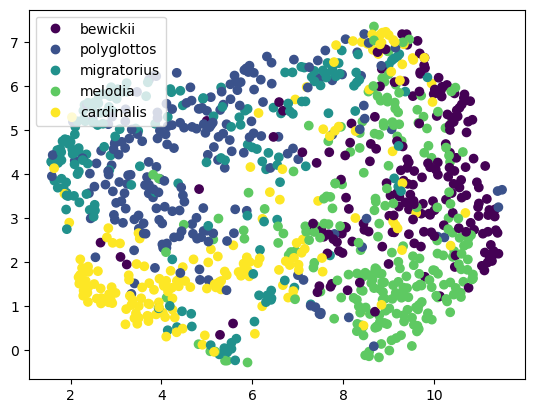

In [24]:
um = umap.UMAP(n_neighbors=23, min_dist=0.3)
u = um.fit_transform(all_embedings)

scatter = plt.scatter(u[:,0], u[:,1], c=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=int_to_spicies)
plt.show()

### Similar sounding spicies

In [17]:
similar_species = {sp:{sim_sp:0 for sim_sp in spicies_to_int} for sp in spicies_to_int}
similar_voices = {sp:(1000,-1,-1) for sp in spicies_to_int}

def find_closest(i, search_in_same_sp=False):
    embs = all_embedings[i]
    color = colors[i]
    closest = -1
    closest_dist = 1000
    for j, emb in enumerate(all_embedings):
        if j == i:
            continue
        if color != colors[j] and search_in_same_sp:
            continue
        if color == colors[j] and not search_in_same_sp:
            continue
        dist = np.linalg.norm(embs - emb)
        if dist < closest_dist:
            closest = j
            closest_dist = dist
    return closest, closest_dist

for i,(wav,sp,_) in enumerate(test_data):
    closest, dist = find_closest(i)
    closest_sp = colors[closest]
    similar_species[int_to_spicies[sp]][int_to_spicies[closest_sp]] += 1
    s_dist,s_i,s_j = similar_voices[int_to_spicies[sp]]
    if dist < s_dist:
        similar_voices[int_to_spicies[sp]] = (dist, i, closest)


In [18]:
for sp in similar_species:
    closest_sp, count = max(similar_species[sp].items(), key=lambda x: x[1])
    print(f"closest to {sp} is {closest_sp} with count = {count}")

closest to bewickii is melodia with count = 123
closest to polyglottos is migratorius with count = 116
closest to migratorius is polyglottos with count = 125
closest to melodia is bewickii with count = 161
closest to cardinalis is polyglottos with count = 67


In [19]:
def display_sound(wav):
    sample, sample_rate = torchaudio.load('wavfiles/' + wav, normalize=True)
    display(Audio(sample[0], rate=sample_rate))
for sp in similar_voices:
    dist,i,j = similar_voices[sp]
    print(f"j ({int_to_spicies[colors[j]]}) is closest to i ({int_to_spicies[colors[i]]}) with distance = {dist}")
    print("i sound: ")
    i_wav = test_data[i][0]
    display_sound(i_wav)
    print("j sound: ")
    j_wav = test_data[j][0]
    display_sound(j_wav)
    ii, dd = find_closest(i,search_in_same_sp=True)
    print(f"closest in same group with distance = {dd}: ")
    ii_wav = test_data[ii][0]
    display_sound(ii_wav)

j (melodia) is closest to i (bewickii) with distance = 0.1476081907749176
i sound: 


j sound: 


closest in same group with distance = 0.4019932746887207: 


j (migratorius) is closest to i (polyglottos) with distance = 0.16418525576591492
i sound: 


j sound: 


closest in same group with distance = 0.2275821417570114: 


j (polyglottos) is closest to i (migratorius) with distance = 0.16418525576591492
i sound: 


j sound: 


closest in same group with distance = 0.1742582768201828: 


j (bewickii) is closest to i (melodia) with distance = 0.1476081907749176
i sound: 


j sound: 


closest in same group with distance = 0.3623005449771881: 


j (bewickii) is closest to i (cardinalis) with distance = 0.18312497437000275
i sound: 


j sound: 


closest in same group with distance = 0.2687772214412689: 
